In [38]:
subj = "Subj1"
exp = "exp_tsne"

n_stages = [ 9, 8, 10 ][int(subj[-1:]) - 1]
scale = False

### Imports

In [39]:
%load_ext autoreload
%autoreload 2

import os

import SDA
import SDA.analytics
import SDA.clustquality
import SDA.stageprocess

import mne
import tqdm
import numpy
import pandas
import matplotlib.pyplot as plt

pandas.set_option("display.precision", 2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data

In [40]:
data = mne.io.read_raw_fif(f"{subj}/src/data_rr_filt-raw.fif")
epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif")

df_features = pandas.read_feather(f"{subj}/{exp}/features.feather")
df_all_features = pandas.read_feather(f"{subj}/{exp}/all_features.feather")

features = df_features.to_numpy()
print('Features: ', features.shape)
print('All features: ', df_all_features.shape)

Opening raw data file Subj1/src/data_rr_filt-raw.fif...
    Range : 3500 ... 471000 =      7.000 ...   942.000 secs
Ready.
Reading d:\HSE\year-3\HSE\CourseProject\Subj1\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1046 matching events found
No baseline correction applied
0 projection items activated
Features:  (1046, 32)
All features:  (1046, 19563)


In [41]:
if subj == "Subj2": # m8 (artifacts at the end)
    epochs = epochs[:-2]
    features = features[:-2]
    df_all_features = df_all_features[:-2]

### SDA

In [42]:
result, df_st_edges = SDA.SDA(scale = scale).apply(features)

Applying to 1046 samples with 32 features each
Running stage 1


  0%|          | 0/589 [00:00<?, ?it/s]

Running stage 2


  0%|          | 0/672 [00:00<?, ?it/s]

In [43]:
edges_true = numpy.loadtxt(f"{subj}/reproduction/internal/best_edges.txt").astype(numpy.int32)
print(edges_true)

metrics = [ ]
for row in tqdm.tqdm(result['St_edges']):
    metrics.append(SDA.clustquality.cluster_metrics_ground(edges_true, row))
result = pandas.concat([ result, pandas.DataFrame(metrics) ], axis = 1)

[   0   39  282  492  560  682  784  857  976 1046]


  0%|          | 0/2016 [00:00<?, ?it/s]

100%|██████████| 2016/2016 [00:07<00:00, 273.44it/s]


In [44]:
result.to_csv(f"{subj}/{exp}/result.csv")
df_st_edges.to_csv(f"{subj}/{exp}/df_st_edges.csv")

### Analysis

In [45]:
def analyze(result: pandas.DataFrame, df_st_edges: pandas.DataFrame, key: str, folder: str):
    if not os.path.exists(f"{subj}/{exp}/{folder}"):
        os.makedirs(f"{subj}/{exp}/{folder}")

    results = SDA.analytics.best_results(result, key = key)
    results.to_csv(f"{subj}/{exp}/{folder}/results.csv")
    display(results)
    
    best_result = SDA.analytics.best_result(result, key = key, n_stages = n_stages)
    best_result_df = pandas.DataFrame([ best_result ])
    best_result_df.to_csv(f"{subj}/{exp}/{folder}/best_result.csv")
    display(best_result_df)
    
    best_edges = numpy.array(best_result['St_edges'])
    numpy.savetxt(f"{subj}/{exp}/{folder}/best_edges.txt", best_edges, fmt = "%d", newline = ' ')
    display(best_edges)

    edge_statistics = SDA.analytics.edge_statistics(features, best_edges)
    edge_statistics.to_csv(f"{subj}/{exp}/{folder}/edge_statistics.csv")
    display(edge_statistics)

    stage_timing = SDA.analytics.stage_timing(best_edges, epochs)
    stage_timing.to_csv(f"{subj}/{exp}/{folder}/stage_timing.csv")
    display(stage_timing)
    
    SDA.analytics.plot_features(df_features, best_edges).savefig(f"{subj}/{exp}/{folder}/features.svg")
    SDA.analytics.plot_eeg_stages(data, best_edges, epochs).savefig(f"{subj}/{exp}/{folder}/eeg_stages.svg")
    SDA.analytics.plot_stats(features, epochs, best_result, df_st_edges).savefig(f"{subj}/{exp}/{folder}/stats.svg")

    return best_edges

#### Internal

,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,40,35,15,3,Mode,"[0, 263, 554, 1046]",1128.69,2.67,2.30e-02,44.13,4.59,0.05,38.42,4.24,0.62,0.42,0.60
1,40,50,10,4,Median,"[0, 199, 554, 682, 1046]",1609.52,3.92,1.20e-02,45.60,6.08,0.09,55.61,2.73,0.68,0.45,0.59
2,60,50,20,5,Median,"[0, 200, 554, 682, 829, 1046]",1466.79,3.93,4.36e-03,39.90,5.81,0.10,51.54,2.88,0.74,0.55,0.65
3,60,35,20,6,Median,"[0, 200, 554, 681, 800, 976, 1046]",1237.92,3.82,-7.41e-06,34.44,6.25,0.09,43.27,2.92,0.78,0.59,0.67
4,60,50,20,7,Median,"[0, 122, 218, 554, 682, 800, 976, 1046]",978.08,3.62,-9.97e-03,32.10,6.06,0.09,34.55,3.04,0.78,0.58,0.65
5,60,50,20,8,Median,"[0, 122, 218, 486, 554, 682, 800, 976, 1046]",668.09,3.29,-1.24e-02,29.41,5.90,0.07,23.85,3.30,0.81,0.65,0.71
6,60,50,20,9,Median,"[0, 122, 200, 263, 486, 554, 682, 800, 976, 1046]",571.24,3.17,-1.69e-02,26.93,5.74,0.07,20.57,3.40,0.83,0.69,0.74
7,60,50,20,10,Median,"[0, 122, 200, 263, 486, 554, 682, 800, 842, 97...",561.29,3.42,-1.59e-02,27.48,6.01,0.08,20.40,3.16,0.84,0.72,0.76
8,60,45,20,11,Mode,"[0, 122, 199, 263, 305, 486, 554, 682, 800, 84...",494.74,3.22,-1.62e-02,25.02,6.21,0.07,18.02,3.59,0.83,0.70,0.74
9,60,45,20,12,Mode,"[0, 122, 199, 263, 305, 444, 486, 554, 682, 80...",439.99,3.02,-1.69e-02,22.88,6.56,0.07,16.05,4.15,0.81,0.64,0.69


,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,60,50,20,9,Median,"[0, 122, 200, 263, 486, 554, 682, 800, 976, 1046]",571.24,3.17,-0.02,26.93,5.74,0.07,20.57,3.4,0.83,0.69,0.74


array([   0,  122,  200,  263,  486,  554,  682,  800,  976, 1046])

,Silh,Cal-Har,Dav-Bold,Ward,Centr
0,0.08,19.00,3.14,446.55,3.06
1,0.06,11.03,3.48,274.13,2.80
2,0.02,9.53,4.35,264.04,2.32
3,0.04,12.07,4.06,340.57,2.56
4,0.09,21.49,2.83,572.58,3.59
5,0.15,54.55,2.09,1495.04,4.93
6,0.07,24.93,3.28,788.81,3.34
7,0.04,11.94,3.95,388.24,2.78


,0,1,2,3,4,5,6,7,8
"Start-end time, sec","(9.9, 117.1)","(117.9, 190.7)","(191.5, 247.5)","(248.3, 449.9)","(450.7, 506.7)","(507.5, 620.3)","(621.1, 722.7)","(723.5, 877.1)","(877.9, 938.7)"
"Time length, sec",107.2,72.8,56.0,201.6,56.0,112.8,101.6,153.6,60.8
Number of epochs,122,78,63,223,68,128,118,176,70


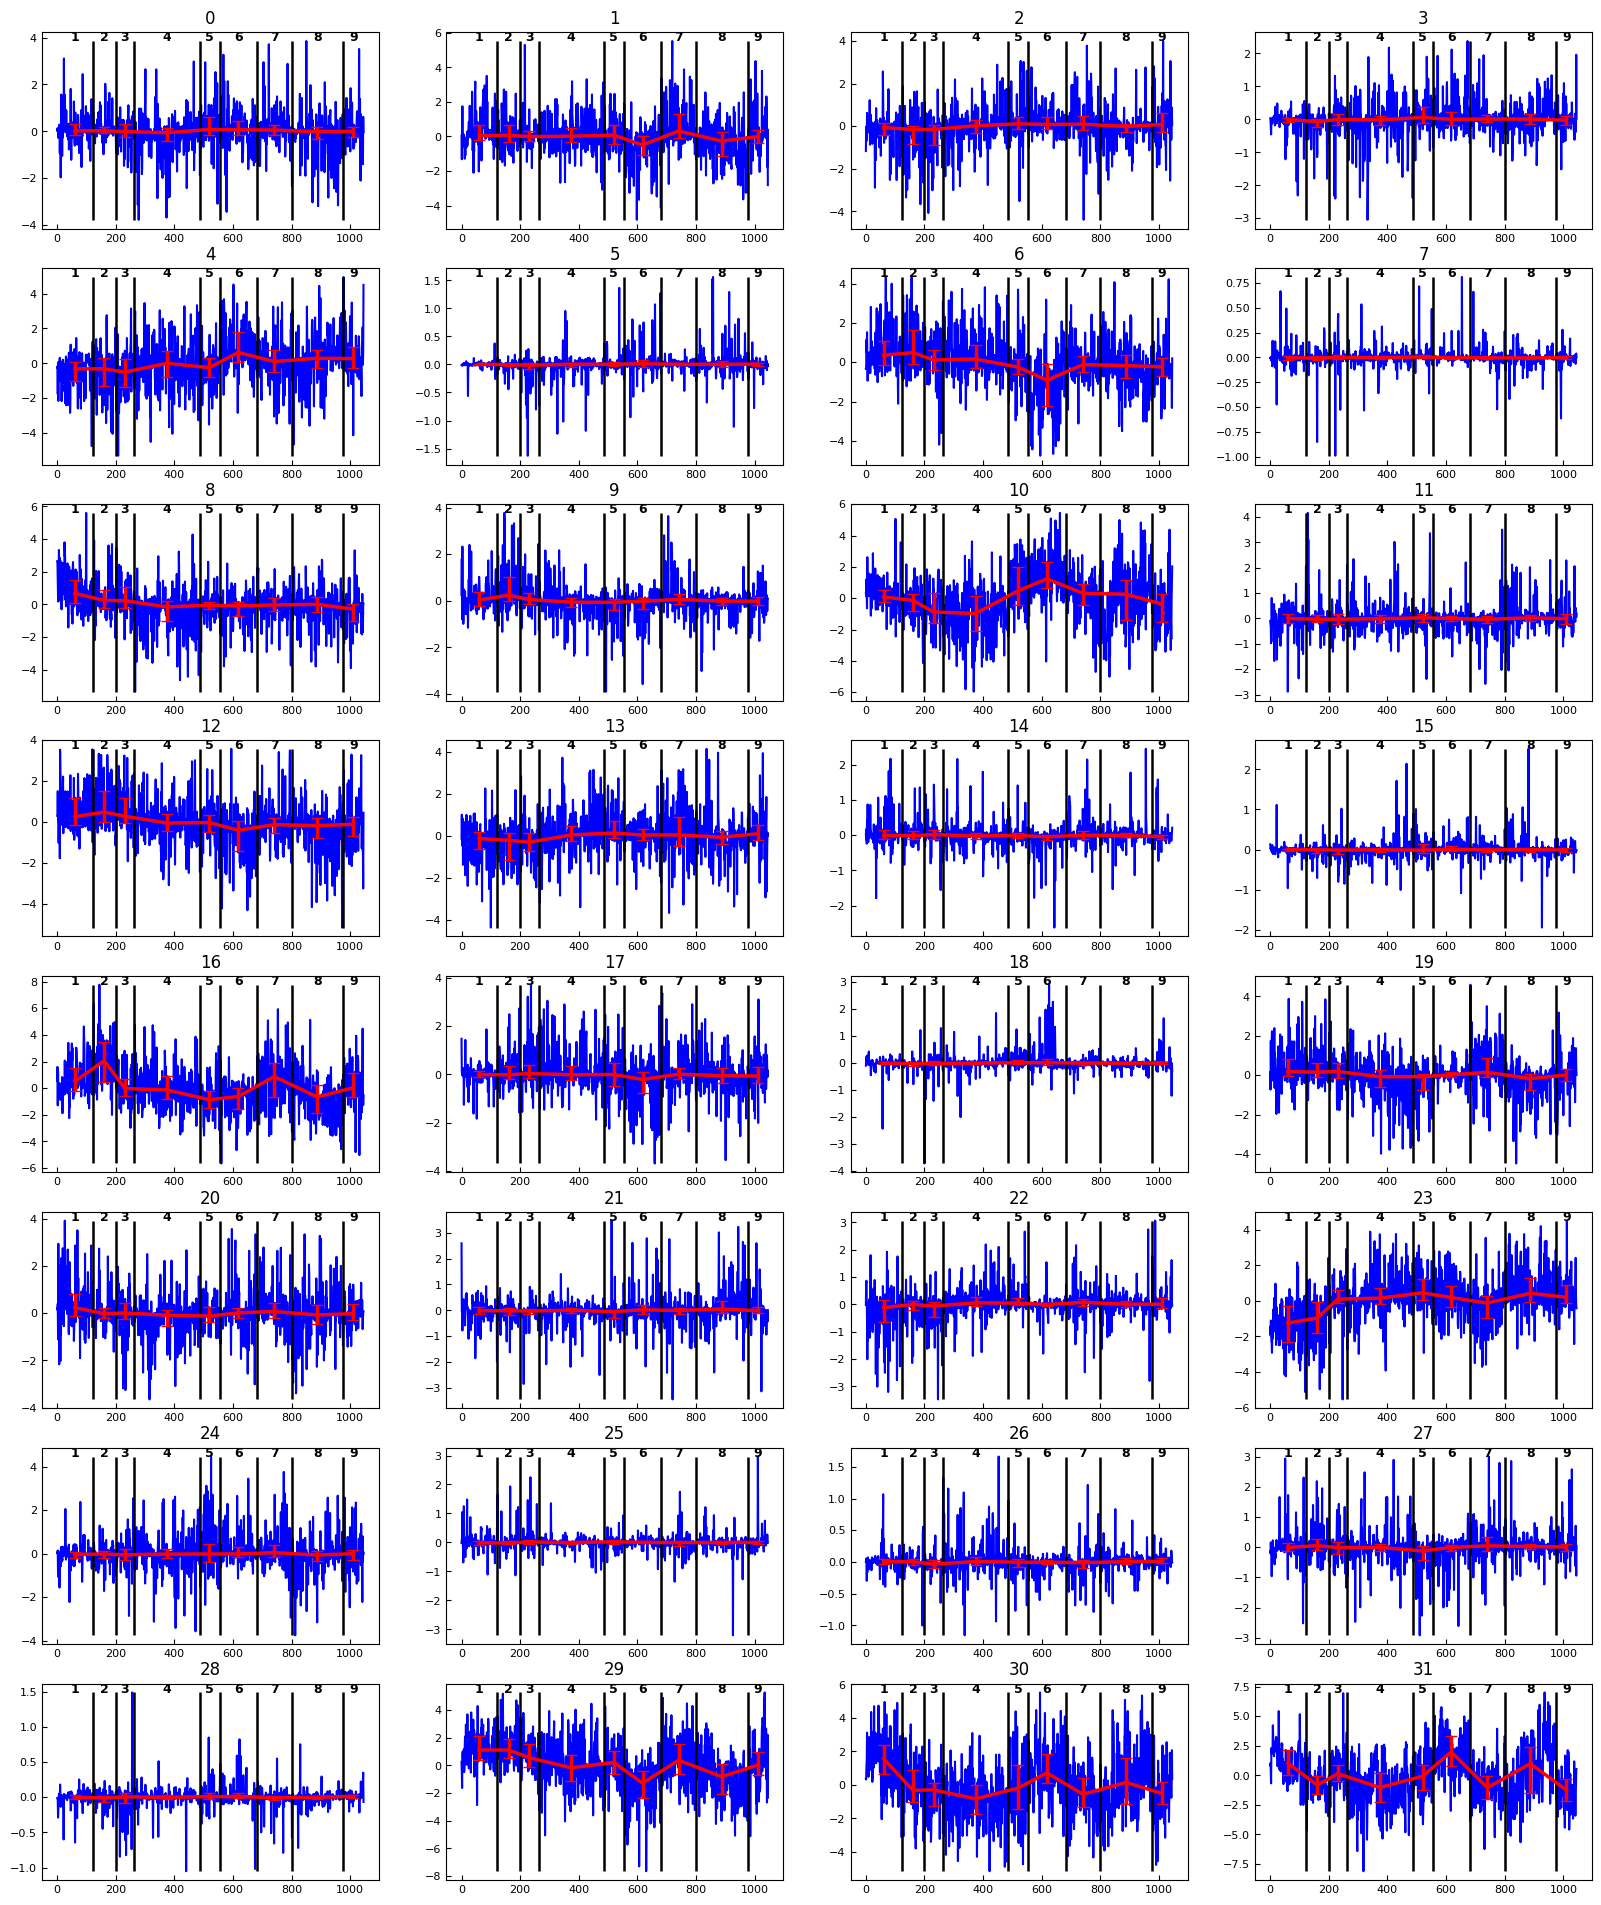

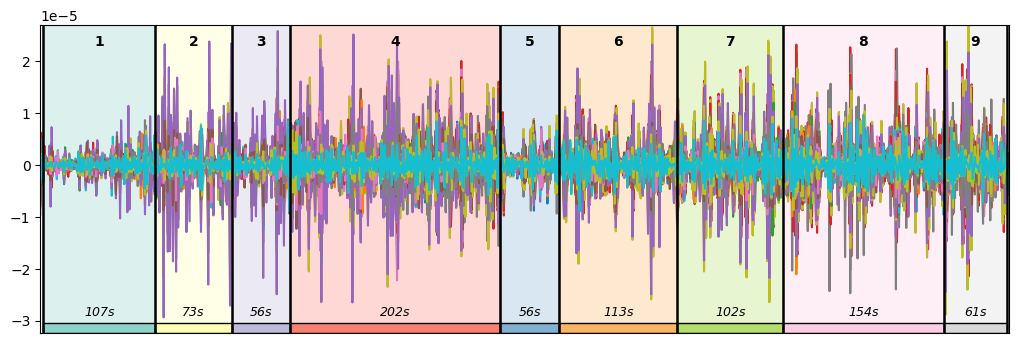

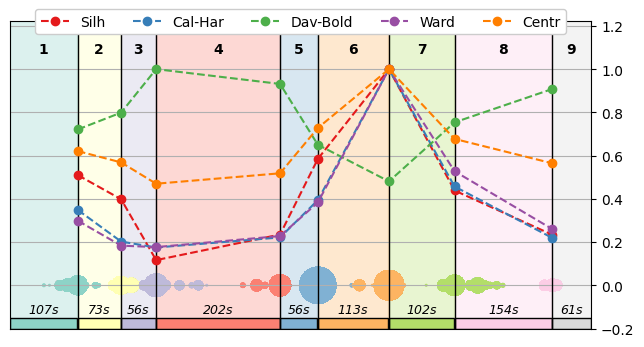

In [46]:
internal_edges = analyze(result, df_st_edges, 'Avg-Silh', "internal")

#### External

,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,40,35,15,3,Mode,"[0, 263, 554, 1046]",1128.69,2.67,2.30e-02,44.13,4.59,0.05,38.42,4.24,0.62,0.42,0.60
1,40,35,15,4,Mode,"[0, 263, 554, 800, 1046]",898.07,2.49,1.22e-02,32.98,6.03,0.05,30.37,4.88,0.73,0.61,0.71
2,60,40,15,5,Mode,"[0, 263, 554, 682, 800, 1046]",1369.62,3.89,3.37e-03,38.72,5.18,0.10,48.31,2.92,0.79,0.67,0.75
3,60,35,20,6,Mode,"[0, 263, 554, 681, 800, 984, 1046]",1184.14,3.72,-4.81e-04,33.19,6.88,0.09,41.30,3.05,0.82,0.72,0.78
4,40,40,15,7,Mode,"[0, 52, 263, 554, 682, 800, 984, 1046]",993.11,3.56,-1.96e-02,30.31,6.40,0.08,34.89,3.11,0.83,0.75,0.79
5,40,45,15,8,Mode,"[0, 52, 263, 486, 554, 682, 800, 931, 1046]",622.00,3.01,-2.13e-02,26.65,6.01,0.06,22.52,4.13,0.85,0.80,0.83
6,40,45,15,9,Median,"[0, 52, 199, 263, 486, 554, 681, 800, 976, 1046]",550.67,3.10,-2.47e-02,26.20,5.76,0.06,19.64,3.48,0.85,0.75,0.78
7,0,50,15,10,Mode,"[0, 52, 263, 340, 486, 554, 682, 800, 931, 104...",426.08,3.08,-4.80e-02,21.32,5.82,0.05,15.46,4.22,0.83,0.74,0.78
8,40,50,20,11,Mean,"[0, 51, 119, 205, 282, 477, 554, 676, 793, 846...",412.09,2.86,-2.84e-02,21.92,6.71,0.06,14.63,3.90,0.84,0.72,0.77
9,40,45,15,12,Median,"[0, 52, 122, 199, 263, 327, 486, 554, 681, 800...",437.13,3.01,-2.69e-02,23.11,6.25,0.06,15.83,3.85,0.83,0.67,0.72


,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,40,45,15,9,Median,"[0, 52, 199, 263, 486, 554, 681, 800, 976, 1046]",550.67,3.1,-0.02,26.2,5.76,0.06,19.64,3.48,0.85,0.75,0.78


array([   0,   52,  199,  263,  486,  554,  681,  800,  976, 1046])

,Silh,Cal-Har,Dav-Bold,Ward,Centr
0,0.04,13.66,3.18,327.60,2.92
1,0.05,11.08,3.91,280.30,2.51
2,0.02,9.27,4.45,257.13,2.27
3,0.04,12.07,4.06,340.57,2.56
4,0.09,21.39,2.83,570.57,3.59
5,0.15,53.32,2.12,1467.37,4.89
6,0.07,24.41,3.33,773.55,3.30
7,0.04,11.94,3.95,388.24,2.78


,0,1,2,3,4,5,6,7,8
"Start-end time, sec","(9.9, 55.5)","(56.3, 189.1)","(190.7, 247.5)","(248.3, 449.9)","(450.7, 506.7)","(507.5, 619.5)","(620.3, 722.7)","(723.5, 877.1)","(877.9, 938.7)"
"Time length, sec",45.6,132.8,56.8,201.6,56.0,112.0,102.4,153.6,60.8
Number of epochs,52,147,64,223,68,127,119,176,70


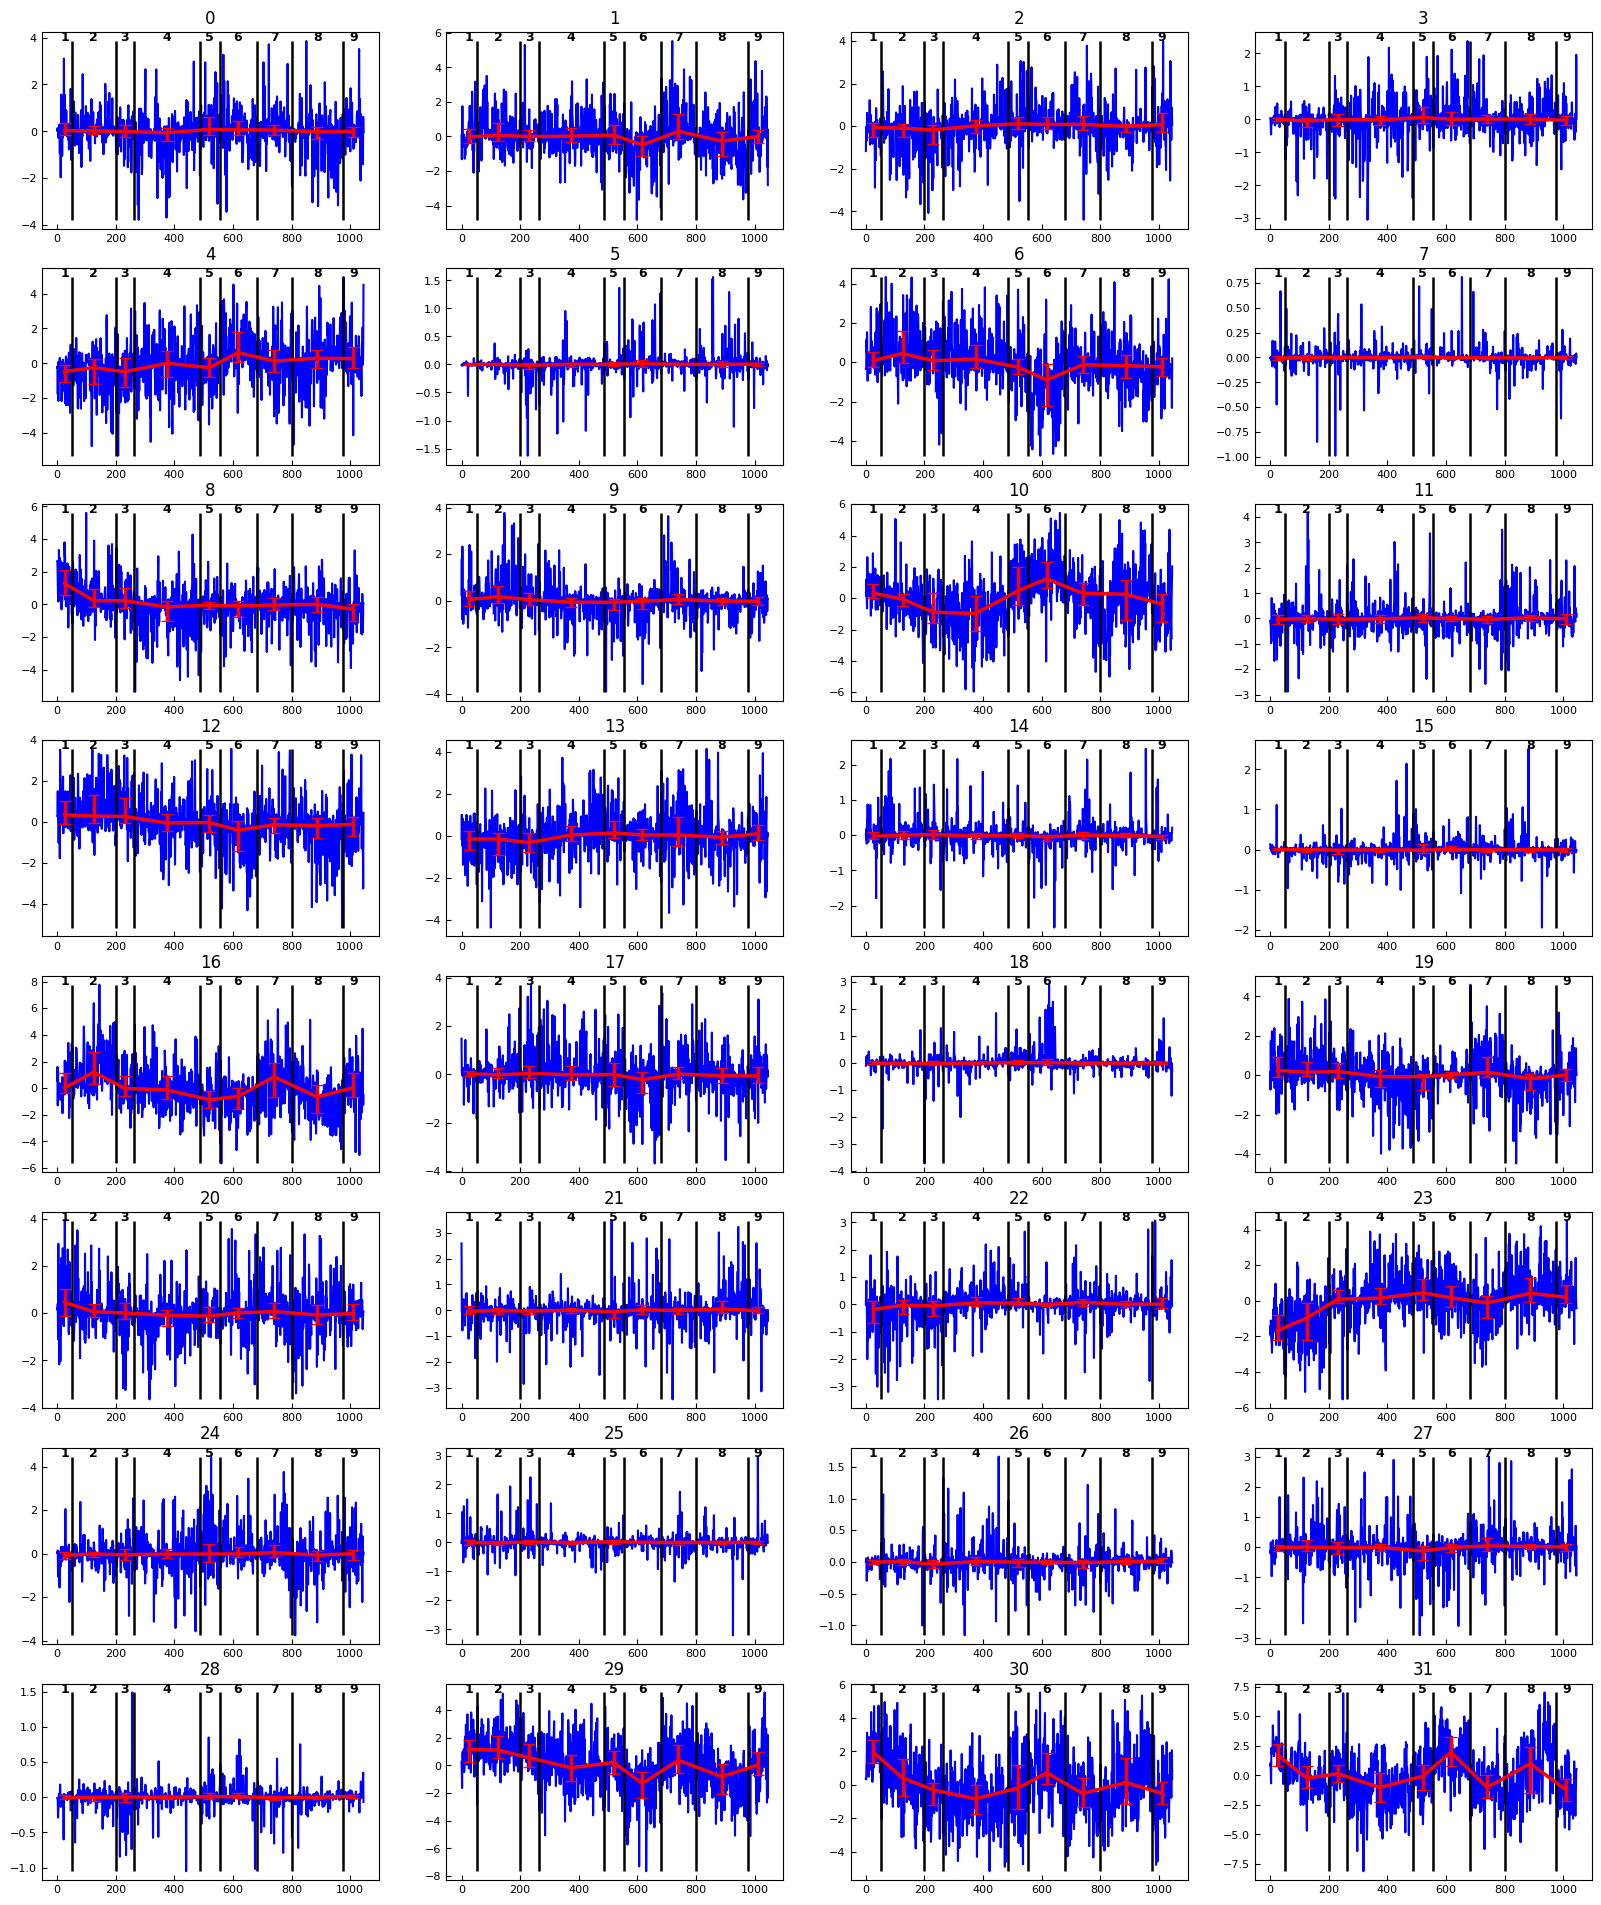

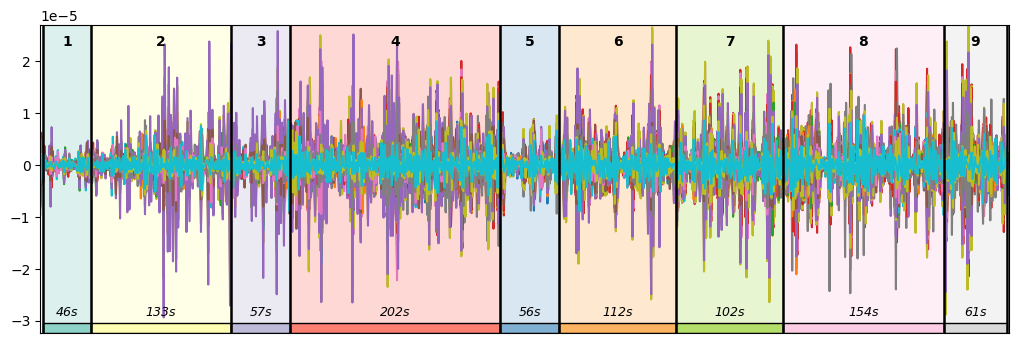

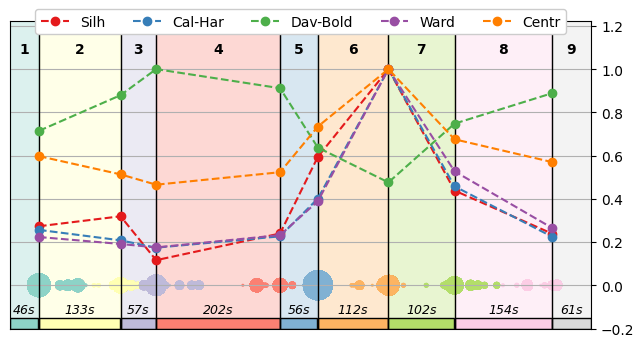

In [47]:
external_edges = analyze(result, df_st_edges, 'FMI', "external")

### IV

In [17]:
IV = pandas.DataFrame(df_all_features.columns, columns = [ "Feature" ])
for edges, name, path in zip(
    [ edges_true, internal_edges, external_edges ],
    [ "true", "internal", "external" ],
    [ "true_iv", "internal/iv", "external/iv" ]
):
    _, labels = SDA.stageprocess.form_stage_bands(edges)
    edges_iv = SDA.analytics.IV.calc_IV_clust(df_all_features, labels)
    edges_iv.to_csv(f"{subj}/{exp}/{path}.csv")
    IV[name] = edges_iv["IV"]
IV

  2%|▏         | 450/19563 [00:13<09:29, 33.55it/s]


KeyboardInterrupt: 

In [ ]:
IV["internal-diff"] = IV["true"] - IV["internal"]
IV["external-diff"] = IV["true"] - IV["external"]
IV.to_csv(f"{subj}/{exp}/IV.csv")
IV

,Feature,true,internal,external,internal-diff,external-diff
0,channel-0 betti dim-1 max,0.34,0.34,0.33,1.92e-03,0.01
1,channel-0 betti dim-1 mean,0.00,0.00,0.00,0.00e+00,0.00
2,channel-0 betti dim-1 std,0.44,0.45,0.40,-3.51e-03,0.05
3,channel-0 betti dim-1 sum,0.00,0.00,0.00,0.00e+00,0.00
4,channel-0 betti dim-1 percentile-25,0.00,0.00,0.00,0.00e+00,0.00
...,...,...,...,...,...,...
19558,overall bd2 dim-3 percentile-75,0.70,0.68,0.62,2.77e-02,0.08
19559,overall bd2 dim-3 kurtosis,0.15,0.15,0.13,2.26e-03,0.02
19560,overall bd2 dim-3 skew,0.19,0.19,0.18,-3.82e-04,0.01
19561,overall bd2 dim-3 norm-1,0.44,0.44,0.40,-3.16e-03,0.04


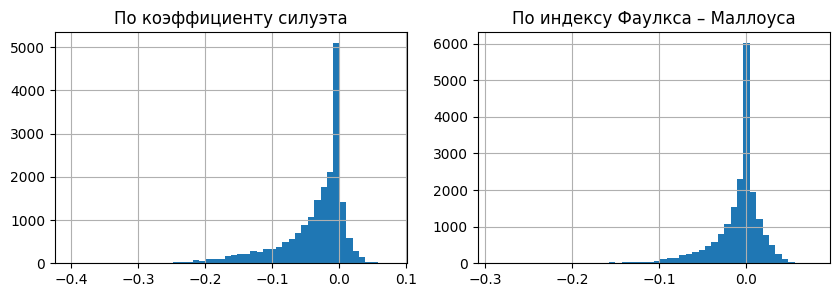

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 3))

axes[0].set_title('По коэффициенту силуэта')
IV["internal-diff"].hist(ax = axes[0], bins = 50)

axes[1].set_title('По индексу Фаулкса – Маллоуса')
IV["external-diff"].hist(ax = axes[1], bins = 50)

plt.savefig(f"{subj}/{exp}/IV-diffs.svg")
plt.savefig(f"{subj}/{exp}/IV-diffs.png")